# 정형화 Weight Regularization 

- 최적화 함수의 weight_decay 로 강도를 조절할 수 있습니다.
- ex) torch.optim.SGD(params, lr=1, momentum=0, dampening=0, weight_decay=0, nesterov=False)
- 모델이 오버피팅할 경우, 적절한 강도로 정형화를 걸어주면 이를 어느정도 극복할 수 있습니다.
- 정형화 부분 빼고는 컨볼루션 인공신경망 코드와 동일합니다.

In [119]:
# 런타임 유형을 GPU로 바꾸시길 추천드립니다.
!pip install torch torchvision

You should consider upgrading via the 'c:\users\public\anaconda3\python.exe -m pip install --upgrade pip' command.


## 1. Settings
### 1) Import required libraries

In [120]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

### 2) Set hyperparameters

In [121]:
batch_size = 512
learning_rate = 0.0005
num_epoch = 100

## 2. Data

### 1) Download Data

In [122]:
# 입력 데이터 정규화(Data_Normalization)
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                         ]),
                         target_transform=None, 
                         download=True)
mnist_test = dset.MNIST("./", train=False, 
                        transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                        ]),
                        target_transform=None, 
                        download=True)

### 2) Check Dataset

In [123]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
mnist_test.__getitem__(0)[0].size(), mnist_test.__len__()

torch.Size([1, 28, 28]) 60000


(torch.Size([1, 28, 28]), 10000)

### 3) Set DataLoader

In [124]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

## 3. Model & Optimizer

### 1) CNN Model

In [125]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100,10)
        )      
        
        # 초기화 하는 방법
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

### 2) Loss func & Optimizer

In [126]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()

# 정형화는 weight_decay로 줄 수 있습니다.
# 다양한 경사하강법 알고리즘이 파이토치에 이미 구현이 되어 있기 때문에 단순하게 이름만 바꿈으로써 해당 알고리즘을 쓸 수 있습니다.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)

# 학습률(Learning_Rate_Decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=1,patience=1,mode='min')    

cuda:0


## 4. Train 

In [127]:
loss_array = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        loss_array.append(loss)
    if i % 10 == 0:
        print(loss)          

tensor(0.3384, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5553, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6017, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5679, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6266, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5992, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6035, device='cuda:0', grad_fn=<NllLossBackward>)


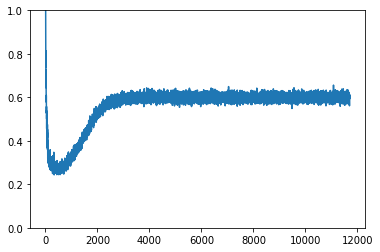

In [128]:
import matplotlib.pyplot as plt

plt.plot(loss_array)
plt.ylim([0,1])
plt.show()

## 5. Test

In [129]:
correct = 0
total = 0

# 배치정규화나 드롭아웃은 학습할때와 테스트 할때 다르게 동작하기 때문에 모델을 evaluation 모드로 바꿔서 테스트해야합니다.
model.eval()
with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 98.51973724365234
